In [110]:
import pandas as pd
import numpy as np
import pandas.api.types as ptypes
import sklearn.decomposition
import random
import matplotlib.pyplot as plt


In [73]:
df = pd.read_csv("./Poland_Train_DataFrame.csv").iloc[:,1:]

In [82]:
df_IMF_FCI_POL = pd.read_csv("IMF_FCI_Poland.csv")

In [75]:
def get_YM_from_datetime(dt):
    return str(dt.year) + "-" + str(dt.month)

In [76]:
def scale_series(series, mean, std):
    return (series - mean)/std

In [125]:
def PCA_module(df: pd.DataFrame):
    ''' Assert the names and the types of the columns. Assert the cov matrix is all positive. '''
    # assert (df.columns[0] == "Date")
    # assert (ptypes.is_datetime64_dtype(df["Date"]))
    assert all(ptypes.is_numeric_dtype(df[col]) for col in df.columns[1:])
    df = df.dropna(axis = "index")
    # assert ((df.cov(numeric_only=True).values > 0).all())

    ''' Get the date range '''
    df = df.sort_values(by= ["Date"], ascending=False)
    print("The date range is :", df["Date"].iat[-1], "to", df["Date"].iat[0])

    # ''' Scale the data '''
    # for col in df.columns[1:]:
    #     df[col] = scale_series(df[col], df[col].mean(), df[col].std())

    ''' Select data frame that ends at 2020-03 '''
    end_index = None
    for index in range(len(df)):
        if df.iloc[index, 0] == "2020-03":
            end_index = index
            break
    assert (end_index is not None)
    df_PCA_decomp = df.iloc[end_index:, 1:3] ##TODO: 1:

    ''' PCA decomposition'''
    pca = sklearn.decomposition.PCA(n_components = len(df_PCA_decomp.columns)) 
    pca.fit(df_PCA_decomp)
    df_transformed = pd.DataFrame(pca.transform(df.iloc[ :, 1:3])) ##TODO: 1:
    df_transformed.insert(0, "Date", df["Date"], True)
    df_combined = df_transformed.merge(df_IMF_FCI_POL, how = 'left',on ="Date")
    corr_coef = np.corrcoef(df_combined.iloc[:, 1:].dropna(), rowvar = False)[-1]


    for i in range(len(df_PCA_decomp.columns)):
        eigenvector = pca.components_[i]
        if (pca.explained_variance_ratio_[i] > 0.3 and ((eigenvector < 0).all() or (eigenvector > 0).all())):
            # output the data combination and eigenvector and explained_variance_ratio
            with open("decomposition result.txt", "a") as f:
                decomp_id = str(random.randint(10**7, 10**8 - 1)) # random id
                print("-"*20, file = f)
                print("id", ":", decomp_id, file = f)
                print("corr_coef", ":", corr_coef[i], file = f)
                print("explain variance ratio", ":", pca.explained_variance_ratio_[i], file = f)
                print("Weight", ":", file = f)
                for name, weight in zip(df_PCA_decomp.columns, eigenvector):
                    print(name, ":", weight, sep = " ", end = "\n", file = f)
                print("-"*20, file = f)
                f.write("\n")

            ## draw figure
            plt.plot(df_combined["Date"], df_combined.iloc[:,1+i], "-", color = "r", label = "PCA")
            plt.plot(df_combined["Date"], df_combined["IMF_FCI"], "-", color = "g", label = "IMF PCA")
            plt.xlabel("Date")
            x_major_locator = plt.MultipleLocator(24)
            ax = plt.gca()
            ax.xaxis.set_major_locator(x_major_locator)
            plt.legend(loc = "best")
            plt.savefig("./fig/"+decomp_id+".jpg")



    ''' '''
    




The date range is : 2005-03 to 2020-03


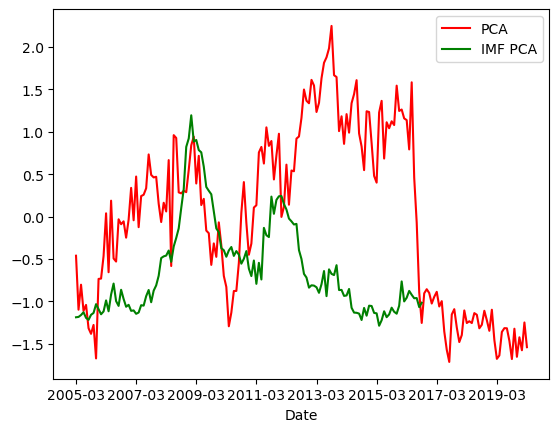

In [126]:
PCA_module(df)